In [25]:
"""
The dependencies required for the program to run include
1.Numpy - Performing Mathematical Calculations
2.MatPlotLib - Library for Ploting Graphs
3.Pandas - For handling the data. Pandas provide many read-made features for reading csv, and handling data as a DataFrame object 
4.Seaborn
5.Random
6.Math
7.Sklearn
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import random
from math import sqrt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1)

# Initializing the Parameters for our Network

Initializer for an L-layer Neural Network.
- The function `parameter_initialization` is a helper function which takes in input a list(dimensions) which contain information about the Layer (both hidden ,input and output layer included) and returns a params dictionary with the requisite size of the params in the given layer using a randomizer function
- Additionally assert is used to make sure that the given parameter matrix matches in size with the dimensions dictionary
- Each layer in the parameter dictionary is represented as Wn and bn where n indicates the nth layer of the network

In [26]:
def parameter_initialization(dimensions):
    
    np.random.seed(4)
    #Initializing the Parameters Dictionary
    params = {}
    #L is used to store the length of the total layers in the network
    L = len(dimensions)            
    #Next we iterate through each layer of the network , filling in the parameter of the network
    for l in range(1, L):
        #np.random.randn(x,y) creates a random array of size x,y drawn from normal distribution
        #We further multiply this matrix with a value of 0.01 to keep the values of the Weights small in the initial iterations of the network
        params['W' + str(l)] = np.random.randn(dimensions[l], dimensions[l-1])*0.01
        params['b' + str(l)] = np.zeros((dimensions[l],1))
        
    return params

# Forward Propagation

With the params in place ,we now perform forward propagation . 

First we start of by defining `forward_prop_lin` module which computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

Next we code `sigmoid` function which performs the $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. operation on the individual elements of the matrix Z.

Also for comparitive purpose we also code `relu` function doing $A = RELU(Z) = max(0, Z)$ . In the later sections of the notebook we ran the code using both relu and sigmoid and have drawn a comparitive study of both the methods

In [27]:
def forward_prop_lin(A, W, b):
    #Z is the input of the activation function which is calculated from the given formula
    Z = np.dot(W,A) + b
    #temp_backprop is a python dictionary , which will be required later in the backward pass
    temp_backprop= (A, W, b)
    
    return Z,temp_backprop

In [28]:
def sigmoid(Z):
    #Using Sigmoid Activator , the function has been described in detail in the markdown
    A = 1/(1+np.exp(-Z))
    temp_backprop= Z
    return A,temp_backprop

In [29]:
def relu(Z):
    #Using Relu Activator, the function has been described in detail in the markdown
    A = np.maximum(0,Z)
    temp_backprop= Z 
    return A,temp_backprop

Now with the linear forward model in place, we next code up the two helper functions `forward_prop_activation` and `forward_prop_full`.

- `forward_prop_activation` takes in input Activations of the previous layer, Weights and bias and applies the requisite activation function i.e sigmoid or relu activator and returns the Activation for the next layer. Also in the process we store thelist_tempbecause they'd be required for future back propagations

- `forward_prop_full` this is the main function , this function sums up the entire forward pass for a training example in the dataset taking in X and params for the entire network

In [30]:
def forward_prop_activation(A_prev, W, b, activation):
    #There are two choice of activations in this code namely sigmoid and relu
    if activation == "sigmoid":
        #If sigmoid is selected we first apply forward_prop_lin to find the pre-activation parameter Z and then apply the sigmoid activator
        Z, linear_temp = forward_prop_lin(A_prev, W, b)
        A, activation_temp = sigmoid(Z)
    
    elif activation == "relu":
        #If relu is selected we first apply forward_prop_lin to find the pre-activation parameter Z and then apply the relu activator
        Z, linear_temp = forward_prop_lin(A_prev, W, b)
        A, activation_temp = relu(Z)

    temp_backprop= (linear_temp, activation_temp)
    #Finally we return the new Activation Parameter for the next layer alongside thelist_tempfor propagation
    return A,temp_backprop

In [31]:
def forward_prop_full(X, params):
    #list_temp for the history of Activations
    list_temp= []
    #Activation A[0] is X in the Base Case
    A = X
    #Since params has 2 params for each Layers . Length of Parameter // 2  returns the Length of the Layer
    L = len(params) // 2           
    
    #Iterating through the individual layers applying Relu Activators for L-1 Layers
    for l in range(1, L):
        #A prev = A[L-1]
        A_prev = A 
        #Here activations of the individual layers are propagated in the iterative fasion using relu activators with the params as specified in the params dictionary
        A,temp_backprop= forward_prop_activation(A_prev, params['W' + str(l)], params['b' + str(l)], "relu")
        list_temp.append(temp_backprop)
        
    #The last layer of the network is a sigmoid activator   
    AL,temp_backprop= forward_prop_activation(A, params['W' + str(L)], params['b' + str(L)], "sigmoid")
    list_temp.append(temp_backprop)
    #Finally we return the Last Level of Activation alongside the list_temp
            
    return AL, list_temp

# Cost Function

Before Coding up BackPropagation we need to define some Cost Function to check if your model is actually learning  for this purpose we compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [32]:
def cost_function(AL, Y):
    #Y.shape[1] returns the no of training example
    m = Y.shape[1]
    #np.multiply is used for the element wise multiplication of the vector
    #longprobs vector is ensured that it has the same shape as Y as we have done element wise multiplication
    mul_temp = np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),1-Y)
    #The cost across various examples are summed up to a single cost value
    cost = (-1/m)*np.sum(mul_temp, axis = 1)
    cost = np.squeeze(cost)      
    
    return cost

# Backpropagation

Now that we have calculated the Cost function , using Cross Entropy Losses. We proceed with the Backpropagation of the Layers , with the updation of the params.

Similiar to Forward Propagation we start of by defining `backward_prop_lin` module which computes the following equations:

Assuming that we have already calculated $dZ$. The outputs $(dW^{[l]}, db^{[l]}, dA^{[l]})$ are computed using the input $dZ^{[l]}$.

$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$

Next we code `derivative_sigmoid` function which performs the 
```python
dZ = derivative_sigmoid(dA, activation_temp)
```
And also `derivative_relu` function which performs
```python
dZ = derivative_relu(dA, activation_temp)
```
If $f(.)$ is the activation function, 
`derivative_sigmoid` and `derivative_relu` compute $$dZ^{[l]} = dA^{[l]} * f'(Z^{[l]}) \tag{11}$$.  

In [33]:
def backward_prop_lin(dZ,temp_backprop):
    #The values of the Previous Activators , Weights and Bias are recovered fromtemp_backprop
    A_prev, W, b =temp_backprop
    m = A_prev.shape[1]

    #The three outputs are calculated using the above formulas
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db

In [34]:
def derivative_relu(dA,temp_backprop):
    #Z recovered fromtemp_backprop
    Z =temp_backprop
    dZ = np.array(dA, copy=True) 
    #DZ for ReLU is straight forward , giving zero for Z<=0 and dA for Z>=0
    dZ[Z <= 0] = 0
    
    return dZ

In [35]:
def derivative_sigmoid(dA,temp_backprop):
    #Z recovered fromtemp_backprop
    Z =temp_backprop
    #DZ for Sigmoid 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

Similiar to the Linear Forward Model we now code up the two helper functions `backward_prop_activation` and `backward_prop_full`.

- `backward_prop_activation` takes in input change in activations of the previous layer,temp_backpropand activation  and applies the requisite activation_backward function by first computing dZ followed by backward_prop_lin function

- `backward_prop_full` this is the main function , this function sums up the entire backward pass for a training example in the dataset taking in X and params for the entire network

In [36]:
def backward_prop_activation(dA,temp_backprop, activation):
    #Retrieving the linear_temp and activation_temp from thetemp_backprop
    linear_temp, activation_temp =temp_backprop
    #Depending upon the activation function speified in the activation we perform a backward pass on the data
    if activation == "relu":
        #if the activator used was relu we first compute Dz from derivative_relu pass and then use backward_prop_lin on the Dz Parameter thus obtained
        dZ = derivative_relu(dA, activation_temp)
        dA_prev, dW, db = backward_prop_lin(dZ, linear_temp)
    
    elif activation == "sigmoid":
        #if the activator used was sigmoid we first compute Dz from derivative_sigmoid pass and then use backward_prop_lin on the Dz Parameter thus obtained
        dZ = derivative_sigmoid(dA, activation_temp)
        dA_prev, dW, db = backward_prop_lin(dZ, linear_temp)
 
    return dA_prev, dW, db

In [37]:
def backward_prop_full(AL, Y, list_temp):
    """
    The final function that sums up the enter backpropagation model
    1. gradients = a dictionary with the gradients which will be used for parameter updation
    2. L = no of layers in the network
    """
    gradients = {}
    L = len(list_temp) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    #To compute DL/DA for rhe first Back Propagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_temp = list_temp[L-1]
    #Updation of the gradient of the final layer which happens to have a sigmoid activator
    gradients["dA" + str(L-1)], gradients["dW" + str(L)], gradients["db" + str(L)] = backward_prop_activation(dAL, current_temp, "sigmoid")

    
    for l in reversed(range(L-1)):
        #Next we iterate through individual Layers of the network calculating the gradients at corresponding layers which are sigmoid activated 
        current_temp = list_temp[l]
        dA_prev_temp, dW_temp, db_temp = backward_prop_activation(gradients["dA" + str(l+1)], current_temp, "relu")
        gradients["dA" + str(l)] = dA_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp

    #Here in this step the gradient is finally returned for parameter updation
    return gradients

# Parameter Updation
With one pass of Forward and Backward Completed , we conclude the pass by Updating the params of each individual layer

In [38]:
def params_update(params, gradients, learning_rate):
    L = len(params) // 2
    # number of layers in the neural network
    # Iterating through Individual params and updating them with the corresponding gradients multiplied by learning_rate
    for l in range(L):
        params["W" + str(l + 1)] = params["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
        params["b" + str(l + 1)] = params["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]
    
    return params

## Final Batch Model 
Having coded all the precomponents of the Network, finally we assemble all of them to form a full fledged network. The function `neural_network_batch` provides the implementation for the batch modeling of the Network. In this, the batch_size is set by the user. The errors are updated only after the processing of a batch

In [39]:
def neural_network_batch(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 3000, print_cost=False,batch_size=32):
    

    np.random.seed(1)
    costs, accu = [],[]                         
    #keep track of cost
    #batch_size=8
    num_batches = X.shape[1]//batch_size
    print("number of batches: " + str(num_batches))
    #Initialize the params for the network using the parameter_initialization helper function
    params = parameter_initialization(layers_dims)
 
    #Iterating throught the whole set num_iterations times, correcting gradients at each level and also collecting the cost to review them later 
    for i in range(0, num_iterations):
        #For every batch of training example we run the algorithm
        for k in range(0,num_batches):
            #X_lite and Y_lite contains batch_size entries of X and Y respectively  for training purpose
            X_lite = X[:,k*batch_size:(k+1)*batch_size]
            Y_lite = Y[:,k*batch_size:(k+1)*batch_size]            
             
            #One pass of Forward Propagation
            AL,list_temp= forward_prop_full(X_lite, params)
            
            if(k==0):
                AL_lite = AL
            else:
                AL_lite = np.concatenate((AL_lite,AL),axis=1)
          
            #Computing the Cost function
            cost = cost_function(AL, Y_lite)
           
        
            #One pass of Backward Propagation
            gradients = backward_prop_full(AL, Y_lite, list_temp)
            
            #Updation of params
            params = params_update(params, gradients, learning_rate)
        
            

        temp_array = AL_lite
        p = np.zeros((1,temp_array.shape[1]))
        for j in range(0, temp_array.shape[1]):
            if temp_array[0,j] > 0.5:
                p[0,j] = 1
            else:
                p[0,j] = 0
        
        Y_acc = Y[:,0:num_batches*batch_size]
        
        # Print the cost every 100 training example
        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            acc1 = np.sum((p == Y_acc)/AL_lite.shape[1])
            print ("Accuracy after iteration %i: %f" %(i, acc1))
        if print_cost and i % 10 == 0:
            costs.append(cost)
            accu.append(acc1)
    print ("Training Accuracy: %f" %(acc1))
    # plot the cost
    #plt.subplot(1, 2, 1)     
    plt.plot(np.squeeze(costs),label='cost')
    plt.plot(np.squeeze(accu),label='accuracy')
    plt.ylabel('metrics')
    plt.xlabel('iterations (per tens)')
    plt.legend()
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params

# Prediction
With the trained model, we are in a position to start making predictions about the independent, unseen training data to assess the credibility of the model. The metric used for the same, is accuracy

In [40]:
def predict(X, y, params):
    """
    To Predict the label , given the dataset X
    """
    
    m = X.shape[1] 
    n = len(params) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # With the model trained , we do one forward pass of the model and check the probability of the label
    temp_array,list_temp= forward_prop_full(X, params)

    
    #If the probability of any label is greater than 0.5 our model predicts it as 1 or 0
    for i in range(0, temp_array.shape[1]):
        if temp_array[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    #As we already know the correct value of the output we can also calculate the accuracy of the model
    print("Test Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

# Loading the Dataset

In [41]:
data1 = pd.read_csv("breast_cancer_preprocessed.csv")

In [42]:
y1 = data1['Class']
X1 = data1.drop(['Class'], 1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [43]:
X1_train = X1_train.T
X1_train.shape

(9, 546)

In [44]:
layers_dims = [X1_train.shape[0], 16, 8, 1]

(1, 546)
number of batches: 34
Cost after iteration 0: 0.711710
Accuracy after iteration 0: 0.670956
Cost after iteration 10: 0.093332
Accuracy after iteration 10: 0.970588
Cost after iteration 20: 0.051814
Accuracy after iteration 20: 0.974265
Cost after iteration 30: 0.046795
Accuracy after iteration 30: 0.976103
Cost after iteration 40: 0.048778
Accuracy after iteration 40: 0.976103
Training Accuracy: 0.976103


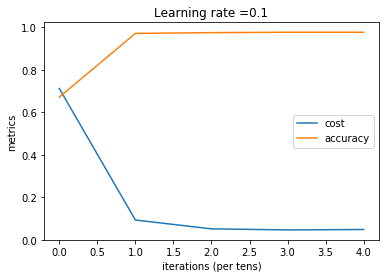

In [45]:
X1_train1 = np.asarray(X1_train)
y1_train1 = np.asarray(y1_train)
y1_train1 = y1_train1.reshape(1, y1_train1.shape[0])
print(y1_train1.shape)
params = neural_network_batch(X1_train1, y1_train1, layers_dims, learning_rate = 0.1, num_iterations = 50, print_cost = True, batch_size = 16)

In [46]:
X1_test = X1_test.T
X1_test = np.asarray(X1_test)

In [47]:
y1_test = np.asarray(y1_test)
y1_test = y1_test.reshape(1, y1_test.shape[0])

In [48]:
pred_test1 = predict(X1_test, y1_test, params)

Test Accuracy: 0.9854014598540144
